In [1]:
import numpy as np
import igraph
from transformers import pipeline



In [2]:
class roberta_stance_model():
    def __init__(self, input_mode):
        self.model = pipeline("text-classification", model="roberta-large-mnli")
        self.label_dict = {'ENTAILMENT': 1,'CONTRADICTION': -1, "NEUTRAL": 0}
        self.input_mode = input_mode
    def forward(self, x:list[tuple[str,str]]): # 'list' or 'dict'
        output_label = None
        if self.input_mode == "list":
            input = [i[0] + " " + i[1] for i in x]
            output_probs  = self.model(input, top_k=None)
            output_label =  [self.label_dict[x[0]['label']] for x in output_probs]
        elif self.input_mode == "dict":
            input = [{"text":i[0] , "text_pair": i[1]} for i in x]
            output_probs  = self.model(input, top_k=None)
            output_label =  [self.label_dict[x[0]['label']] for x in output_probs]
        return output_probs, output_label

In [ ]:
class Discourse():
    def __init__(self, stance_model):
        self.discourse_history = []
        self.stance_graph = igraph.Graph(directed = True)
        self.stance_model = stance_model
        self.no_stance_update_vertex_idx = 0
        self.no_edges = 0

    def add_statements_vertices(self, statements: list[tuple[int, str]]):
        no_statements = len(statements)
        self.discourse_history.extend(statements)
        start_vertex_idx = len(self.stance_graph.vs)
        end_vertex_idx = start_vertex_idx + no_statements
        new_vertex_id = range(start_vertex_idx, end_vertex_idx)
        new_vertex_membership = [user for user, statement in statements] #Define membership for new vertices
        self.stance_graph.add_vertices(no_statements, attributes = {"v_id": new_vertex_id,
                                                                    "membership": new_vertex_membership })
        assert len(self.discourse_history) == len(self.stance_graph.vs)
        
    def update_stance_graph_edges(self):
        start_vertex_idx = self.no_stance_update_vertex_idx
        end_vertex_idx = len(self.discourse_history)
        
        if(start_vertex_idx == 0):
            new_to_old_edges = [(v1,v2) for v1 in range(start_vertex_idx, end_vertex_idx) for v2 in range(start_vertex_idx, end_vertex_idx) if v1!=v2] 
            new_to_old_edge_stances, old_to_new_edge_stances = self.get_stance(new_to_old_edges)
            self.add_edges(new_to_old_edges, new_to_old_edge_stances)
        
        else:
            #edges from new vertex to old vertices #end_vertex_idx used in place of len(self.discourse_history)
            new_to_old_edges = [(new_vertex_idx, old_vertex_idx) for new_vertex_idx in range(start_vertex_idx, end_vertex_idx) for old_vertex_idx in range(0,start_vertex_idx)]
            #edges from old vertex to new vertices 
            old_to_new_edges = [(old_vertex_idx, new_vertex_idx) for new_vertex_idx, old_vertex_idx in new_to_old_edges]
        
            new_to_old_edge_stances, old_to_new_edge_stances = self.get_stance(new_to_old_edges)

            self.add_edges(new_to_old_edges, new_to_old_edge_stances)
            self.add_edges(old_to_new_edges, old_to_new_edge_stances)
        

        self.no_stance_update_vertex_idx = end_vertex_idx
        
    def add_edges(self, edges:list[tuple[int,int]], stances:list[int]):
        new_e_ids = range(self.no_edges, self.no_edges+len(edges))
        self.stance_graph.add_edges(edges, attributes = {"stance": stances, "e_id": new_e_ids})
        self.no_edges+=len(edges)
    
    def get_stance(self, edges: list[tuple[int,int]]):
        #change to the dict output expected by
        statements = [(self.discourse_history[i][1], self.discourse_history[j][1]) for i,j in edges]
        
        reverse_statements = statements[::-1]
        edge_probs, edge_stances = self.stance_model.forward(statements)
        reverse_edge_probs, reverse_edge_stances = self.stance_model.forward(statements)

        # reverse_edge_stances = edge_stances #Use to increase performace
        return edge_stances, reverse_edge_stances
    
    def plot_stance_graph(self, allowed_vertex_membership: list[int], allowed_v_id: list[int], allowed_stances: list[int], allowed_e_id: list[int]):
        membership_subgraph = self.stance_graph.subgraph(self.stance_graph.vs.select(membership_in = allowed_vertex_membership))
        stance_subgraph = membership_subgraph.subgraph_edges(membership_subgraph.es.select(stance_in = allowed_stances), delete_vertices = True)
        
        desired_subgraph = 
        # Assign vertex memberships (for colors)
        # g = g.subgraph_edges(g.es.select(stance_in = allowed_stances), delete_vertices = True)
        # Map memberships to vertex colors
        vertex_colors = ['red', 'blue', 'orange', 'green', 'purple']  # example palette
        vcolor = [vertex_colors[m % len(vertex_colors)] for m in g.vs['membership']]

        # Map stance to edge colors
        stance_color_map = {1: 'green', 0: 'gray', -1: 'red'}
        ecolor = [stance_color_map[s] for s in g.es['stance']]

        # Layout
        layout = g.layout('fr')  # Fruchterman-Reingold layout

        # Plot
        igraph.plot(
            g,
            layout=layout,
            vertex_color=vcolor,
            vertex_size=40,
            edge_color=ecolor,
            vertex_label=[str(i) for i in range(g.vcount())],
            bbox=(600, 600),
            margin=50
        )

In [4]:

class FallacyChecker():
    def __init__(self, stance_graph: igraph.Graph):
        self.stance_graph = stance_graph
    
    def get_cycle(self, allowed_vertex_membership: list[int], allowed_stances: list[int]) -> tuple[list[tuple], list[tuple]]:
        membership_subgraph = self.stance_graph.subgraph(self.stance_graph.vs.select(membership_in = allowed_vertex_membership))
        stance_subgraph = membership_subgraph.subgraph_edges(membership_subgraph.es.select(stance_in = allowed_stances), delete_vertices = True)

        basis_cycles_edge_idx = stance_subgraph.minimum_cycle_basis()
        basis_cycle_vertices_id = []
        basis_cycle_edges_id = []
        for edge_cycle in basis_cycles_edge_idx:
            temp_vertices = []
            temp_edge_id = []
            # print(edge_cycle)
            for edge in edge_cycle:
                # print(edge)
                v1_idx, v2_idx = stance_subgraph.get_edgelist()[edge]
                v1_id = stance_subgraph.vs["v_id"][v1_idx]
                v2_id = stance_subgraph.vs["v_id"][v2_idx]
                vertices_id = [v1_id, v2_id]
                edge_id = stance_subgraph.es["e_id"][edge]
                temp_edge_id.append(edge_id)                
                temp_vertices.extend(vertices_id)
                
            basis_cycle_edges_id.append(temp_edge_id)    
            basis_cycle_vertices_id.append(tuple(set(temp_vertices)))   
        # print("EID: ", basis_cycles_edge_idx["e_id"]) 
        return basis_cycle_edges_id, basis_cycle_vertices_id
    
    def get_contradiction(self, allowed_vertex_membership: list[int]):
        allowed_stances = [-1]
        
        membership_subgraph = self.stance_graph.subgraph(self.stance_graph.vs.select(membership_in = allowed_vertex_membership))
        contradiction_stance_subgraph = membership_subgraph.subgraph_edges(membership_subgraph.es.select(stance_in = allowed_stances), delete_vertices = True)
        
        contradiction_vertices_id =  []
        for edge in contradiction_stance_subgraph.get_edgelist():
            v1_idx, v2_idx = edge
            v1_id = contradiction_stance_subgraph.vs["v_id"][v1_idx]
            v2_id = contradiction_stance_subgraph.vs["v_id"][v2_idx]
            contradiction_vertices_id.append((v1_id, v2_id))
        return contradiction_vertices_id

In [ ]:
def plot

In [48]:
from debate_datasets import Ethix_data
Ethix_dataset = Ethix_data(r"C:\All Codes\BTP\New_Igraph\Ethix_dataset.csv")

debate_idx = 12
scheme_list = Ethix_dataset.iloc[debate_idx]["Scheme"]
argument_text = Ethix_dataset.iloc[debate_idx]["Argument"]
print(scheme_list)
print(argument_text)
debate_data = list(zip(scheme_list, argument_text))
print(debate_data)
# Create list of tuples [(number, debate_text), ...]
# debate_data = [(num, debate) for num , debate in (scheme_list, debate_text)]


[2, 4, 7, 2, 3, 6, 0, 4, 3, 4, 0, 3, 0, 6, 0, 3, 4, 4, 0, 3, 3, 3, 0, 7, 0, 5, 0, 2, 5, 3, 3, 6, 2, 2, 0, 0, 5, 3, 0, 7, 0, 2, 0, 2, 0, 6, 5, 7, 2, 5, 1, 3, 2, 2]
['If drugs were legalised, the drug trade would be less able to fuel serious crime.', 'Around half of the total income of criminal organisations comes from illicit drug trafficking. Without this, they would lose significant power.', 'The legalisation of alcohol after Prohibition in the US greatly decreased the ability of gangs to make money from alcohol sales.', 'Legalization of drugs would have significant economic benefits for the state and its citizens, rather than criminal gangs.', 'Legalisation would create jobs, which would likely improve employment rates. This would prevent people from turning to crime in order to generate income.', 'Drug legalisation is not necessary for governments to funnel more money into harm reduction and other social programmes, which could equally combat socioeconomic deprivation.', 'Redistribu

In [54]:
print(len(scheme_list))

54


In [49]:
model = roberta_stance_model(input_mode = "list")
d = Discourse(model)

d.add_statements_vertices(debate_data)

d.update_stance_graph_edges()

Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0


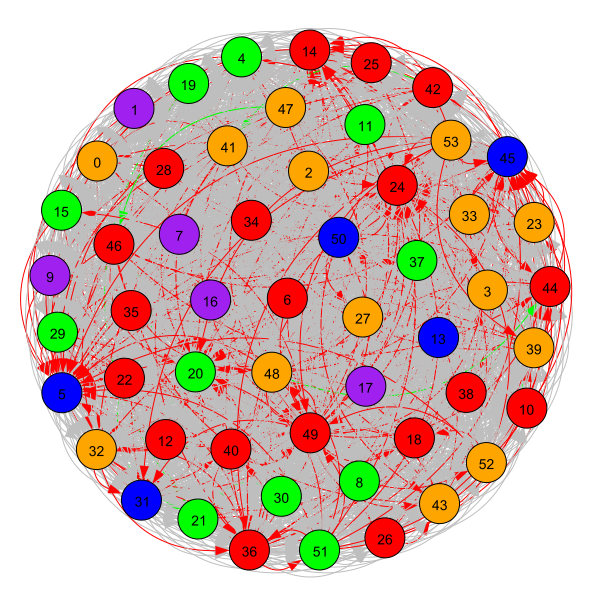

In [55]:
g = d.stance_graph
allowed_stances = [1]
# Assign vertex memberships (for colors)
# g = g.subgraph_edges(g.es.select(stance_in = allowed_stances), delete_vertices = True)
# Map memberships to vertex colors
vertex_colors = ['red', 'blue', 'orange', 'green', 'purple']  # example palette
vcolor = [vertex_colors[m % len(vertex_colors)] for m in g.vs['membership']]

# Map stance to edge colors
stance_color_map = {1: 'green', 0: 'gray', -1: 'red'}
ecolor = [stance_color_map[s] for s in g.es['stance']]

# Layout
layout = g.layout('fr')  # Fruchterman-Reingold layout

# Plot
igraph.plot(
    g,
    layout=layout,
    vertex_color=vcolor,
    vertex_size=40,
    edge_color=ecolor,
    vertex_label=[str(i) for i in range(g.vcount())],
    bbox=(600, 600),
    margin=50
)

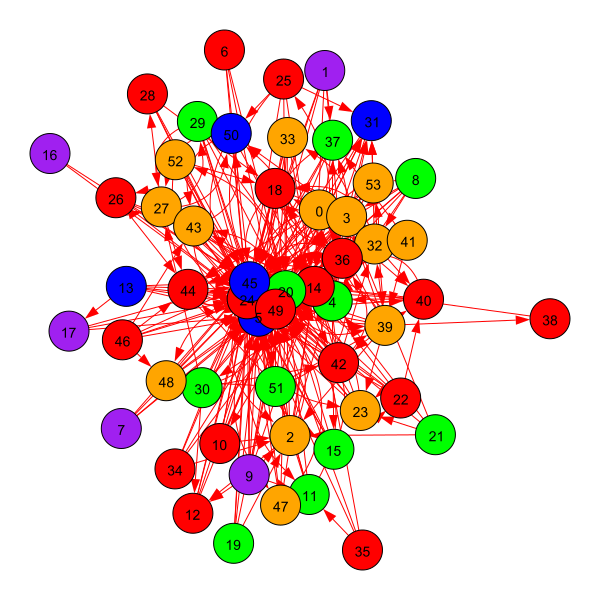

In [57]:
g = d.stance_graph
allowed_stances = [-1]
# Assign vertex memberships (for colors)
g = g.subgraph_edges(g.es.select(stance_in = allowed_stances), delete_vertices = True)
# Map memberships to vertex colors
vertex_colors = ['red', 'blue', 'orange', 'green', 'purple']  # example palette
vcolor = [vertex_colors[m % len(vertex_colors)] for m in g.vs['membership']]

# Map stance to edge colors
stance_color_map = {1: 'green', 0: 'gray', -1: 'red'}
ecolor = [stance_color_map[s] for s in g.es['stance']]

# Layout
layout = g.layout('fr')  # Fruchterman-Reingold layout

# Plot
igraph.plot(
    g,
    layout=layout,
    vertex_color=vcolor,
    vertex_size=40,
    edge_color=ecolor,
    vertex_label=[str(i) for i in range(g.vcount())],
    bbox=(600, 600),
    margin=50
)

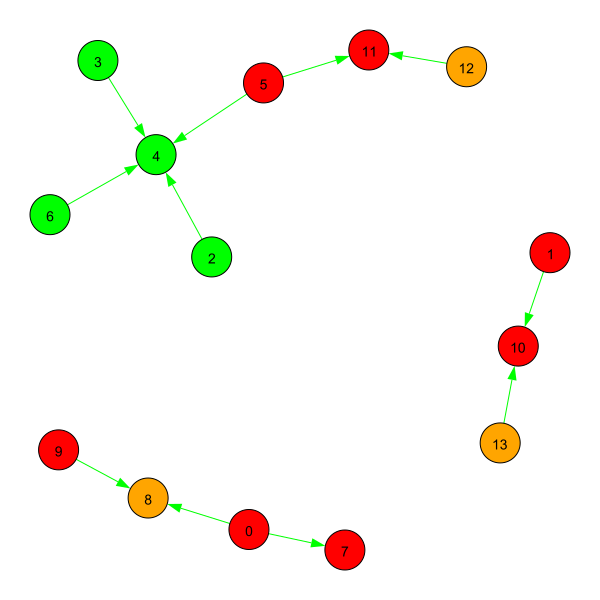

In [58]:
g = d.stance_graph
allowed_stances = [1]
# Assign vertex memberships (for colors)
g = g.subgraph_edges(g.es.select(stance_in = allowed_stances), delete_vertices = True)
# Map memberships to vertex colors
vertex_colors = ['red', 'blue', 'orange', 'green', 'purple']  # example palette
vcolor = [vertex_colors[m % len(vertex_colors)] for m in g.vs['membership']]

# Map stance to edge colors
stance_color_map = {1: 'green', 0: 'gray', -1: 'red'}
ecolor = [stance_color_map[s] for s in g.es['stance']]

# Layout
layout = g.layout('fr')  # Fruchterman-Reingold layout

# Plot
igraph.plot(
    g,
    layout=layout,
    vertex_color=vcolor,
    vertex_size=40,
    edge_color=ecolor,
    vertex_label=[str(i) for i in range(g.vcount())],
    bbox=(600, 600),
    margin=50
)

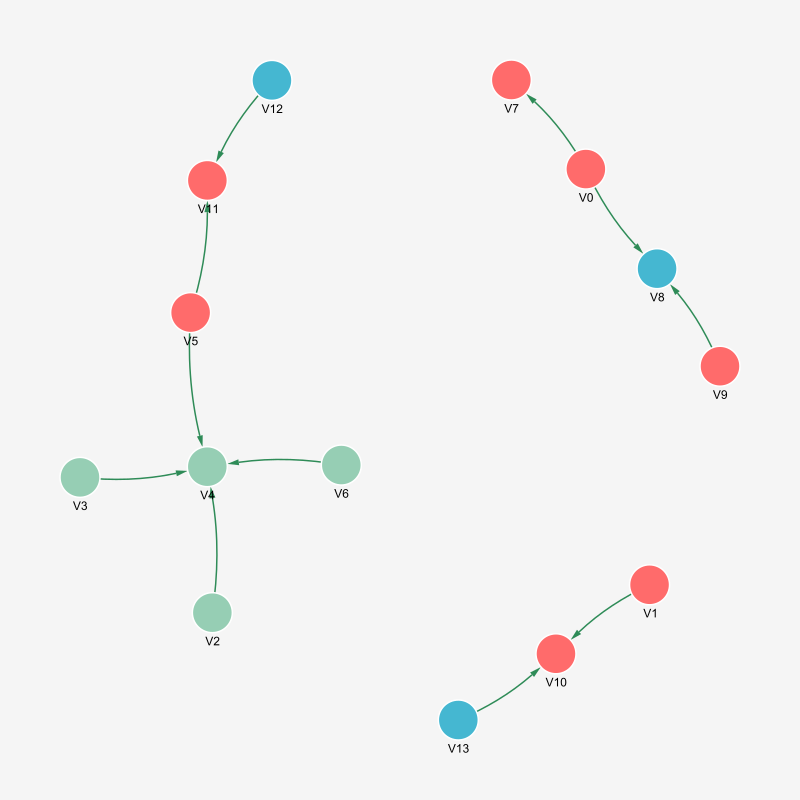

In [52]:
import igraph as ig

g = d.stance_graph
allowed_stances = [1]
# Assign vertex memberships (for colors)
g = g.subgraph_edges(g.es.select(stance_in = allowed_stances), delete_vertices = True)
# Map memberships to vertex colors - more distinct colors
vertex_colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7']  # modern color palette
vcolor = [vertex_colors[m % len(vertex_colors)] for m in g.vs['membership']]

# Map stance to edge colors
stance_color_map = {1: '#2E8B57', 0: '#808080', -1: '#DC143C'}  # richer colors
ecolor = [stance_color_map[s] for s in g.es['stance']]

# Layout
layout = g.layout('fr')  # Fruchterman-Reingold layout

# Enhanced plotting with thinner, neater edges
visual_style = {
    'layout': layout,
    'vertex_color': vcolor,
    'vertex_size': 40,
    'vertex_frame_width': 1.5,
    'vertex_frame_color': 'white',
    'vertex_label': [f"V{i}" for i in range(g.vcount())],
    'vertex_label_color': 'black',
    'vertex_label_size': 12,
    'vertex_label_dist': 1.2,
    'edge_color': ecolor,
    'edge_width': 1.5,  # Thinner edges
    'edge_arrow_size': 0.8,  # Smaller arrow heads
    'edge_arrow_width': 0.8,
    'edge_curved': 0.1,  # Less curvature for straighter edges
    'bbox': (800, 800),
    'margin': 80,
    'background': '#f5f5f5'
}

# Plot the graph
ig.plot(g, **visual_style)

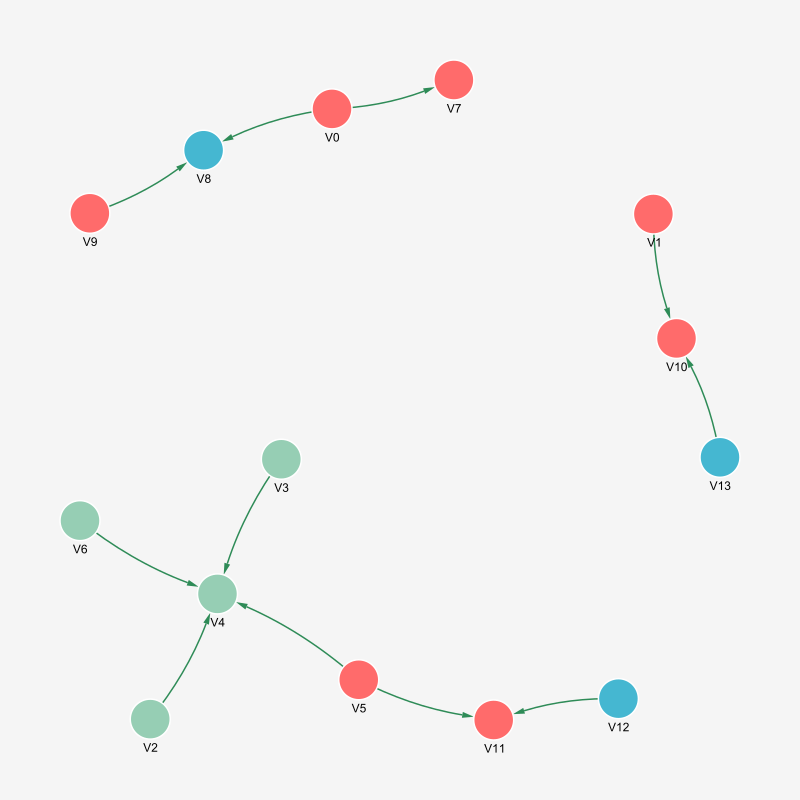

In [53]:
import igraph as ig

g = d.stance_graph
allowed_stances = [1]
# Assign vertex memberships (for colors)
g = g.subgraph_edges(g.es.select(stance_in = allowed_stances), delete_vertices = True)

# Map memberships to vertex colors - more distinct colors
vertex_colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7']  # modern color palette
vcolor = [vertex_colors[m % len(vertex_colors)] for m in g.vs['membership']]

# Map stance to edge colors
stance_color_map = {1: '#2E8B57', 0: '#808080', -1: '#DC143C'}  # richer colors
ecolor = [stance_color_map[s] for s in g.es['stance']]

# Layout
layout = g.layout('fr')  # Fruchterman-Reingold layout

# Enhanced plotting with thinner, neater edges
visual_style = {
    'layout': layout,
    'vertex_color': vcolor,
    'vertex_size': 40,
    'vertex_frame_width': 1.5,
    'vertex_frame_color': 'white',
    'vertex_label': [f"V{i}" for i in range(g.vcount())],
    'vertex_label_color': 'black',
    'vertex_label_size': 12,
    'vertex_label_dist': 1.2,
    'edge_color': ecolor,
    'edge_width': 1.5,  # Thinner edges
    'edge_arrow_size': 0.8,  # Smaller arrow heads
    'edge_arrow_width': 0.8,
    'edge_curved': 0.1,  # Less curvature for straighter edges
    'bbox': (800, 800),
    'margin': 80,
    'background': '#f5f5f5'
}

# Plot the graph
ig.plot(g, **visual_style)